# In a given country, is the average number of volunteers per event changing every year?

First, let's load in the data.

In [24]:
import pandas as pd
import sqlite3

old = pd.read_csv('../data/cleanups.csv')[['Year', 'TotalVolunteers', 'COUNTRY']]
new = pd.read_csv('../data/new-cleanups.csv')
new = pd.DataFrame({'Year': pd.to_datetime(new['Cleanup Date']).dt.year, 'COUNTRY': new['Country'], 'TotalVolunteers': new['People']})
cleanups = pd.concat([new, old]).reset_index().drop(columns=['index'])
cleanups = cleanups.rename(columns={'COUNTRY': 'Country', 'TotalVolunteers': 'Volunteers'})

/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,21,22,23,24,34,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/abhinavmadahar/Documents/ocean_plastic_pollution/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We solve this using either a $Z$-test or a $t$-test.
To run a $Z$-test on two populations $1$ and $2$, we calculate
$$
    Z = \frac{\overline{X_1}-\overline{X_2}}{\sqrt{\frac{S_1^2}{N_1}+\frac{S_2^2}{N_2}}}
$$
where $X_i$ is the mean of the sample of the $i^{\text{th}}$ population, $S_i^2$ is the variance of the sample of the $i^{\text{th}}$ population, and $N_i$ is the count of the sample of the $i^{\text{th}}$ population.
To run a $t-$test, we calculate (source: Saed Sayed)
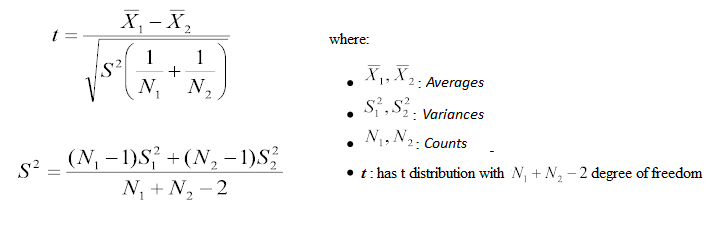

If we have at least 30 data points in each sample, we run a $Z$-test.
If one of the samples has fewer than 30 data points, we run a $t$-test.
Let's set up a function that can run a $Z$-test or a $t$-test to compare (country 1, year 1) and (country 2, year 2).
Note that country 1 and country 2 need not be different, and the same applies for year 1 and year 2.

In [133]:
from scipy.stats import norm
from scipy.stats import t
import matplotlib.pyplot as plt

def statistical_difference_in_number_of_volunteers(country_1: str, year_1: int, country_2: str, year_2: int, alpha: float = 0.05) -> (bool, int):
    sample_1 = cleanups[(cleanups['Country'] == country_1) & (cleanups['Year'] == year_1)]
    sample_2 = cleanups[(cleanups['Country'] == country_2) & (cleanups['Year'] == year_2)]
    
    X_1 = sample_1['Volunteers'].mean()
    X_2 = sample_2['Volunteers'].mean()
    
    S_1 = sample_1['Volunteers'].std()
    S_2 = sample_2['Volunteers'].std()
    
    N_1 = sample_1['Volunteers'].count()
    N_2 = sample_2['Volunteers'].count()
    
    if N_1 == 0 or N_2 == 0:
        return False, float('nan')
    
    if N_1 >= 30 and N_2 >= 30:
        Z = abs(X_1 - X_2) / (S_1 ** 2 / N_1 + S_2 ** 2 / N_2) ** 0.5
        p = norm.cdf(Z)
    else:
        S = ((N_1 - 1) * S_1 ** 2 + (N_2 - 1) * S_2 ** 2) / (N_1 + N_2 - 2)
        t_value = (X_1 - X_2) / (S ** 2 * (1 / N_1 + 1 / N_2)) ** 0.5
        df = N_1 + N_2 - 2
        p = t.cdf(t_value, df)
    
    return p > 1 - alpha, p

With this, we can compare two countries to see if the cleanups in those countries in a single year have the same number of volunteers per event at $\alpha = 0.05$.

In [134]:
statistical_difference_in_number_of_volunteers('United States', 2017, 'Malaysia', 2017, alpha=0.05)

(False, 0.8570591256118119)

Let's make a diagram.
Given a country and a year, we find all the other countries in that year where the difference in the average number of beach cleanup events in that year is statistically significant.
In the shown countries, the number of volunteers per event is different from that of Malaysia, and the darker countries are more likely to be different.
The countries which are not shown have basically the same volunteers per event as Malaysia.

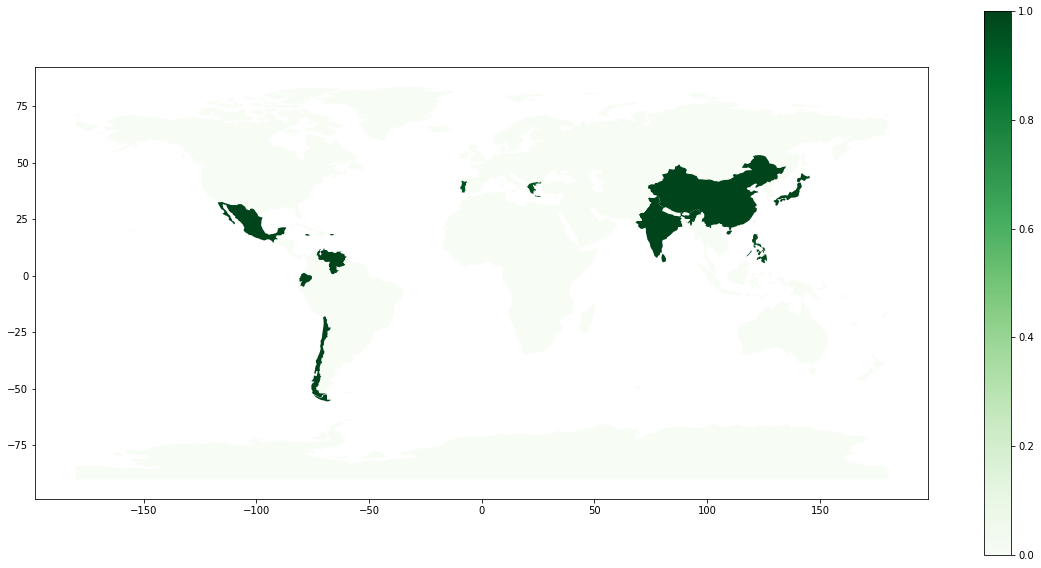

In [167]:
import pycountry
import geopandas

alpha = 0.05
year = 2017
base_country = 'Malaysia'

probabilities = {country: statistical_difference_in_number_of_volunteers(base_country, year, country, year, alpha) for country in cleanups['Country'].unique()}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')).set_index('iso_a3')
world.loc[:, 'Probability'] = [0 for _ in range(len(world))]

for country, (different, probability) in probabilities.items():
    try:
        abbreviation = pycountry.countries.search_fuzzy(country)[0].alpha_3
        if abbreviation in world.index and different:
            world.loc[abbreviation, 'Probability'] = probability
    except:
        pass

world.plot(column='Probability', legend=True, figsize=(20, 10), cmap='Greens');